In [1]:
import sys
sys.path.append("..")

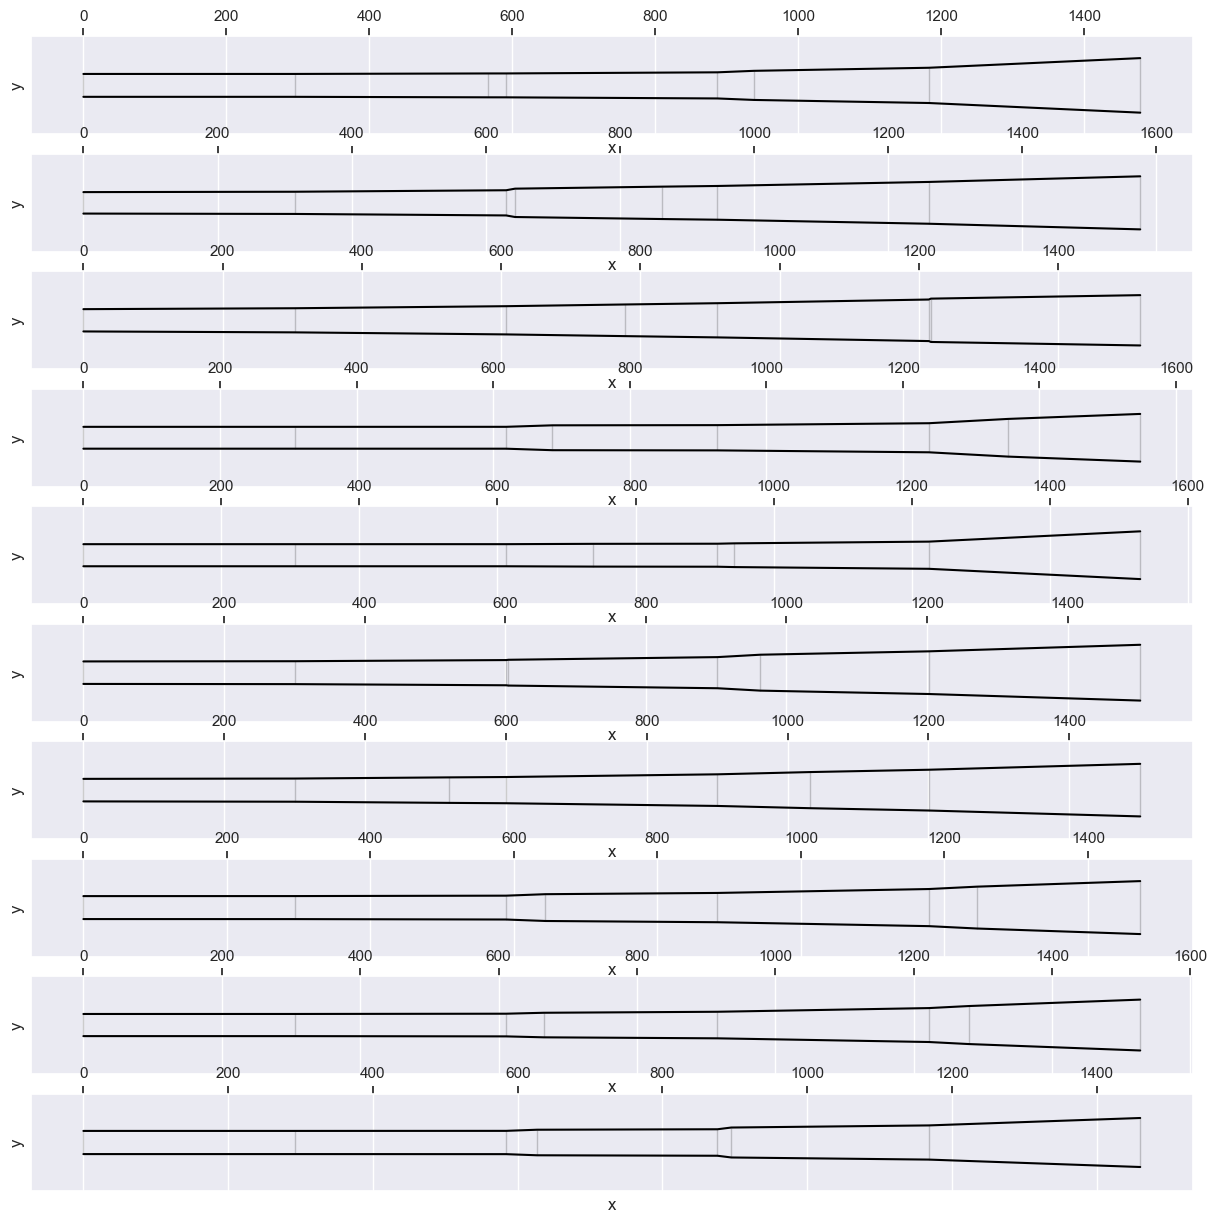

In [246]:
from didgelab.evo.shapes import Shape
from didgelab.calc.geo import Geo, geotools
from didgelab.calc.conv import note_to_freq
from didgelab.util.didge_visualizer import vis_didge
from didgelab.evo.mutator import MutationRateMutator
import numpy as np

class BasicShape(Shape):
    
    def __init__(
            self,
            n_bubbles=1,
            n_bubble_segments=10,
            n_segments = 10
        ):
        
        Shape.__init__(self)

        self.d1=32
        self.n_segments = n_segments
        
        self.add_param("length", 1450, 1600)
        self.add_param("bellsize", 65, 80)
        self.add_param("power", 1,2)
        
        self.add_param("widening_1_x", 500, 800)
        self.add_param("widening_1_y", 1.0, 1.3)
        self.add_param("widening_2_x", 800, 1400)
        self.add_param("widening_2_y", 1.0, 1.3)
        
        self.n_bubbles=n_bubbles
        self.n_bubble_segments=10
        for i in range(self.n_bubble_segments):
            self.add_param(f"bubble{i}_width", 100, 200)
            self.add_param(f"bubble{i}_height", 0, 15)
            self.add_param(f"bubble{i}_pos", -0.3, 0.3)
        
    def make_geo(self):
        length = self.get_value("length")
        bellsize = self.get_value("bellsize")

        x = length*np.arange(self.n_segments+1)/self.n_segments
        y= np.arange(self.n_segments+1)/self.n_segments
        
        
        p = self.get_value("power")
        y = np.power(y, p)
        y = np.power(y, p)
        y = np.power(y, p)
        y = self.d1 + y*(bellsize - self.d1)
        
        widenings = [[self.get_value(f"widening_{i}_x"), self.get_value(f"widening_{i}_y")] for i in range(1,3)]
        for w in widenings:
            geo = list(zip(x,y))
            d=geotools.diameter_at_x(Geo(geo), w[0])
            
            add_d = w[1]*d - d
            for i in range(len(geo)):
                if geo[i][0] >= w[0]:
                    break
            
            x = np.concatenate((x[0:i], [w[0]], x[i:]))
            y_right = np.concatenate(([d], y[i:])) + add_d
            y = np.concatenate((y[0:i], y_right))
        
            y[i:] /= y[-1]/bellsize
            
        shape = list(zip(x,y))
        
        bubble_length = length-100

        for i in range(self.n_bubbles):
            
            width = self.get_value(f"bubble{i}_width")
            height = self.get_value(f"bubble{i}_height")
            pos = self.get_value(f"bubble{i}_pos")
                
            x = width * np.arange(self.n_bubble_segments)/self.n_bubble_segments
            y = height * np.sin(np.arange(self.n_bubble_segments)*np.pi/self.n_bubble_segments)
            
            x += bubble_length * i/self.n_bubbles
            x += (0.5+pos)*bubble_length/self.n_bubbles
                        
            if x[0] < 0:
                x += -1*x[0]
                x += 1
            if x[-1] > bubble_length:
                x -= x[-1] - (bubble_length)
            
            geo = Geo(shape)
            y += np.array([geotools.diameter_at_x(geo, _x) for _x in x])
            
            shape = list(filter(lambda a : a[0]<x[0] or a[0]>x[-1], shape))
            shape.extend(zip(x,y))
            shape = sorted(shape, key=lambda x : x[0])
        
        return Geo(shape)
    
father = BasicShape(n_bubbles=0, n_segments=5)
mutator = MutationRateMutator()

n_mutants=10
mutants = [mutator.mutate(father) for i in range(n_mutants)]

plt.figure(figsize=(15,15))
for i in range(len(mutants)):
    plt.subplot(len(mutants), 1, i+1)
    vis_didge(mutants[i].make_geo())


In [283]:
class MutationRateMutator:

    def __init__(self):
        pass

    def mutate(self, father, mutation_rate=1.0, mutation_probability = 1.0):
        mutant = father.copy()

        maxima = np.array([x.maximum for x in mutant.parameters])
        minima = np.array([x.minimum for x in mutant.parameters])
        values = np.array([x.value for x in mutant.parameters])

        diff = mutation_rate * ((np.random.random(len(values))  * (maxima-minima) ) + minima - values)
        print(diff[0])
        mutations = np.array([0.0])
        i=0
        while mutations.sum() == 0.0 and i<10:
            mutations = np.random.choice((1,0), size=len(diff), p=(mutation_probability, 1-mutation_probability))
            i+=1

        diff = diff*mutations

        new_values = values + diff

        # make shure the values are within minima and maxima range
        new_values_before = new_values.copy()
        indizes = new_values<minima
        new_values[indizes] = minima[indizes]
        indizes = new_values>maxima
        new_values[indizes] = maxima[indizes]

        for i in range(len(new_values)):
            mutant.parameters[i].value = new_values[i]

        mutant.loss = -1

        return mutant
    
mutator = MutationRateMutator()

n_mutants=10
mutants = [mutator.mutate(father) for i in range(n_mutants)]

lengths = [m.get_value("length") for m in mutants]
lengths

42.06264697975098
40.514288599618794
-32.44848984239775
65.92269758266002
-66.17763069594912
-67.48115651174794
-62.887582630448605
-7.063133875678204
16.772829233621906
0.5862343947110276


[1567.062646979751,
 1565.5142885996188,
 1492.5515101576023,
 1590.92269758266,
 1458.8223693040509,
 1457.518843488252,
 1462.1124173695514,
 1517.9368661243218,
 1541.772829233622,
 1525.586234394711]

In [272]:
maxima = np.array([2000])
minima = np.array([1000])
values = np.array([1500])

d=[]
for i in range(10):
    diff = ((np.random.random(len(values))  * (maxima-minima) ) + minima - values)
    print(diff)


[-343.71041833]
[-62.14644466]
[-52.46446378]
[-246.78984192]
[-142.31953496]
[407.71724955]
[-231.49888075]
[170.0438483]
[-116.92685548]
[-186.25993032]


,freq,impedance,rel_imp,note-number,cent-diff,note-name
796,75.246745,2.989998e+07,1.000000,-31,-42.637059,D1
1531,175.893366,9.790558e+06,0.327444,-16,-12.637059,F2
1947,284.422265,4.309639e+06,0.144135,-8,-44.637059,C#3
2236,397.154699,3.485876e+06,0.116585,-2,-22.637059,G3
2448,507.368659,1.672984e+06,0.055953,2,-46.637059,B4
2622,620.329359,1.253444e+06,0.041921,6,5.362941,D#4
2760,727.543952,1.111176e+06,0.037163,9,29.362941,F#4
2893,848.374391,7.196243e+05,0.024068,11,-36.637059,G#4
2997,956.678652,6.380108e+05,0.021338,13,-44.637059,A#5


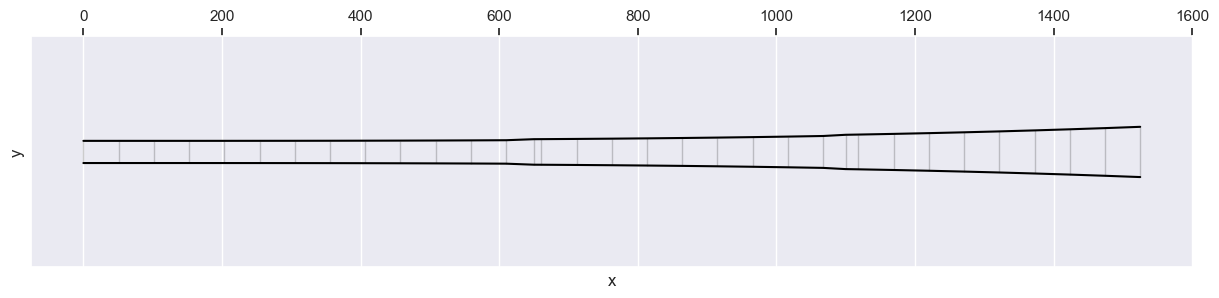

In [26]:
shape2 = BasicShape(n_bubbles=0, n_segments=30)
geo2 = shape2.make_geo()
vis_didge(geo2)
geo2.get_cadsd().get_notes()

,freq,impedance,rel_imp,note-number,cent-diff,note-name
793,74.986411,2.579968e+07,1.000000,-31,-36.637059,D1
1530,175.690284,6.232947e+06,0.241590,-16,-10.637059,F2
1931,279.213314,5.473507e+06,0.212154,-8,-12.637059,C#3
2216,388.083673,2.502280e+06,0.096989,-2,17.362941,G3
2445,505.613297,4.412596e+05,0.017103,2,-40.637059,B4
2610,611.789101,1.021711e+06,0.039602,6,29.362941,D#4
2738,709.286131,1.798493e+06,0.069710,8,-26.637059,F4
2930,885.423546,4.590832e+05,0.017794,12,-10.637059,A5


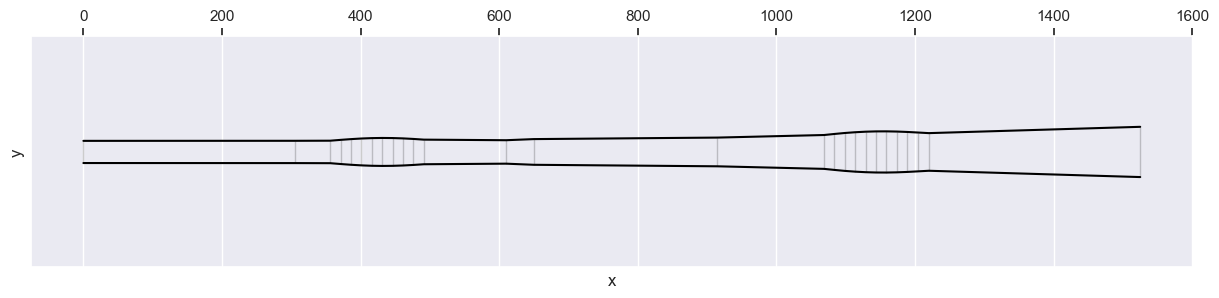

In [39]:
class DetailShape(Shape):
    
    def __init__(self, father_shape : Shape):
        Shape.__init__(self)
        
        geo = father_shape.make_geo().geo
        self.d1 = geo[0][1]
        self.num_segments = len(geo)
        for i in range(1, len(geo)):
            x=geo[i][0]
            minx = 0.8*x
            maxx = 1.2*x
            self.add_param(f"x{i}", minx, maxx, value=x)
            
            y=geo[i][1]
            miny = 0.8*y
            maxy = 1.2*y
            self.add_param(f"y{i}", miny, maxy, value=y)
            
            
    def make_geo(self):
        x = [0]
        y = [self.d1]
        for i in range(1, self.num_segments):
            x.append(self.get_value(f"x{i}"))
            y.append(self.get_value(f"y{i}"))
        geo = list(zip(x,y))
        return Geo(geo)
            
shape3 = DetailShape(shape1)
geo3 = shape3.make_geo()
vis_didge(geo3)
geo3.get_cadsd().get_notes()

In [286]:
import pandas as pd
import os
evolutions_folder="../../evolutions/"
subfolders = sorted(os.listdir(evolutions_folder))
latestfolder = os.path.join(evolutions_folder, subfolders[-1])
df = pd.read_csv(os.path.join(latestfolder, "losses.csv"))
steps = []
df = df.query("i_generation<i_generation.max()")
df

x = df.i_generation.unique()
for i_mutant in df.i_mutant.unique():
    plt.plot(x,df.query("i_mutant==@i_mutant").loss)
    


FileNotFoundError: [Errno 2] No such file or directory: '../../evolutions/2023-09-05T22-44-13_test/losses.csv'

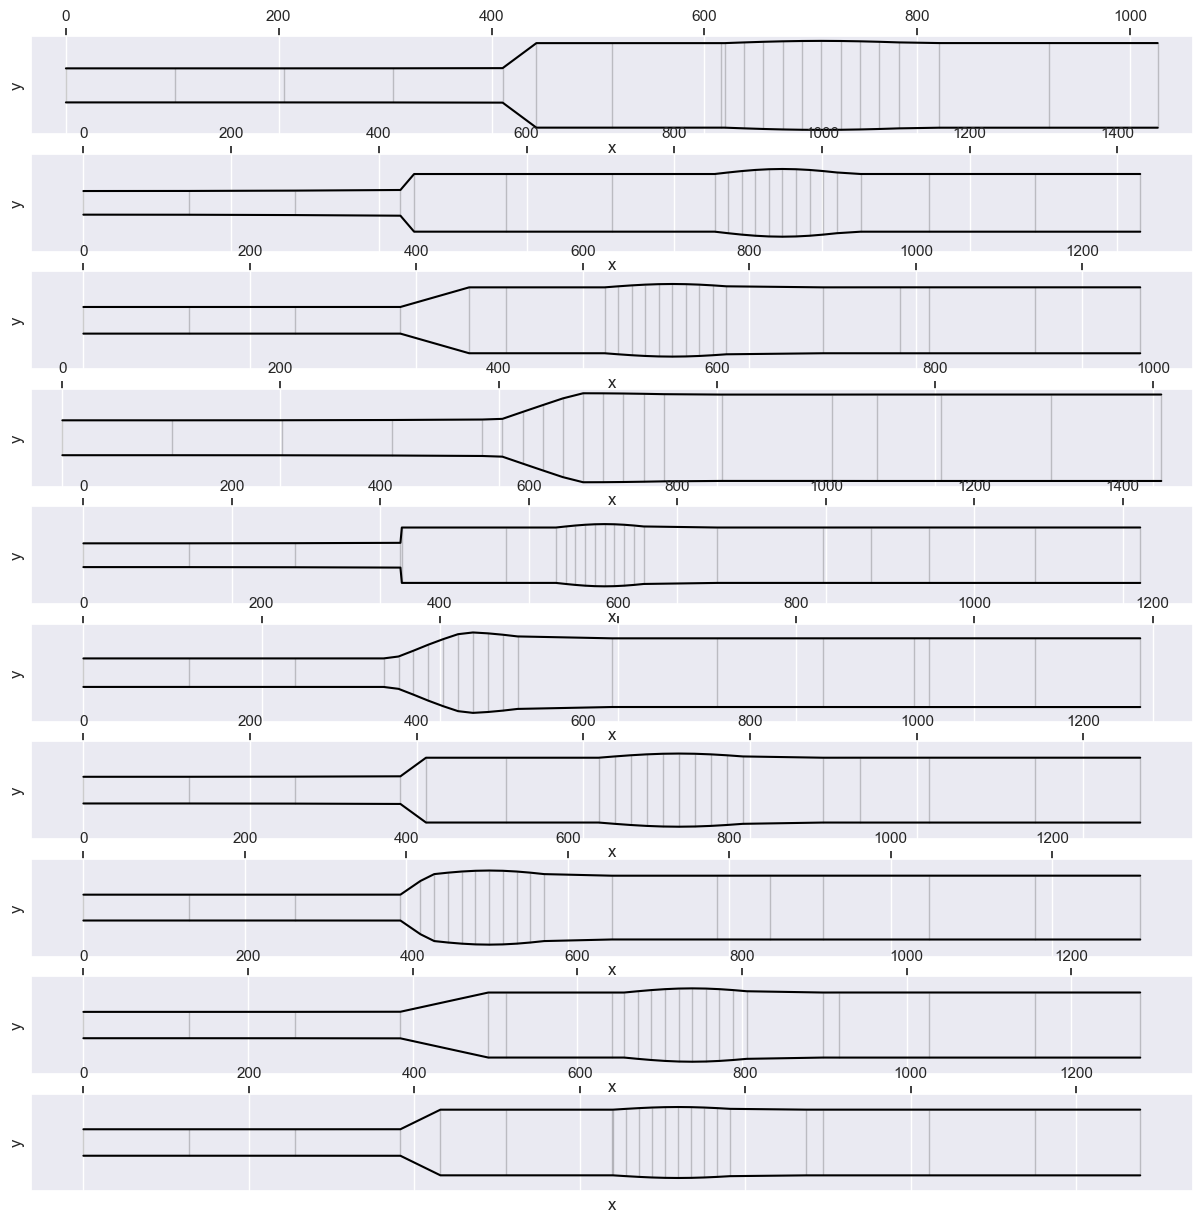

In [241]:
from didgelab.util.didge_visualizer import vis_didge

import json
f = os.path.join(latestfolder, "checkpoint_final_1", "geos.json")
geos = json.load(open(f, "r"))

plt.figure(figsize=(15,15))
for i in range(len(geos)):
    plt.subplot(len(geos), 1, i+1)
    vis_didge(Geo(geos[i]))


10

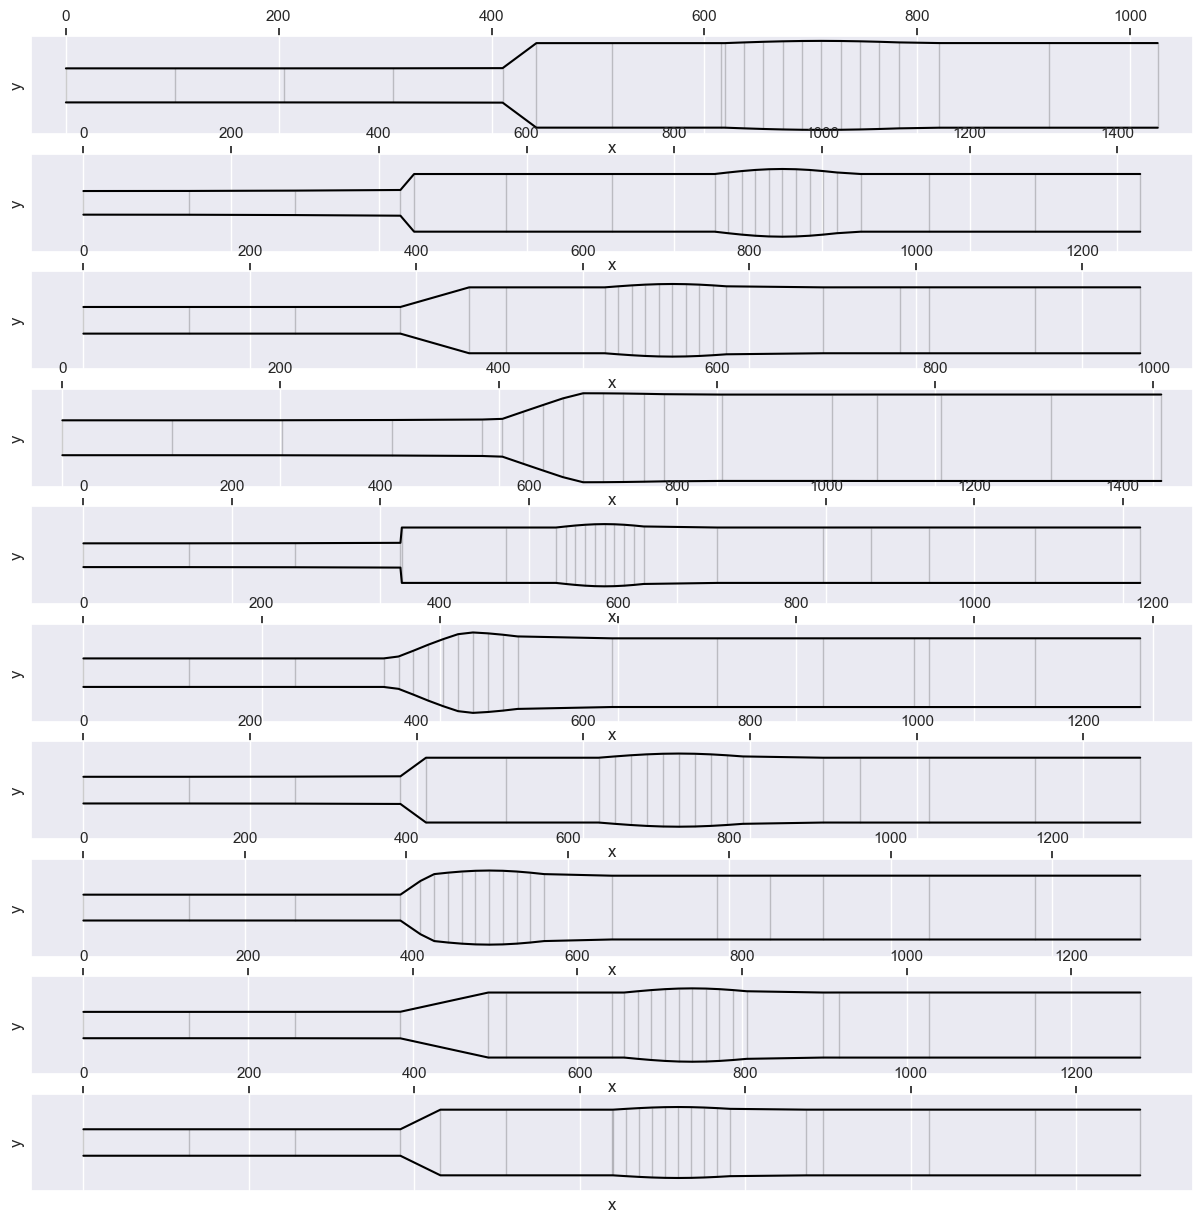

In [240]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
n_mutants = 8
for i in range(len(geos)):
    plt.subplot(len(geos), 1, i+1)
    vis_didge(Geo(geos[i]))


In [202]:
d = {'minima': [1000.0, 65.0, 1.0, 0.3, 1.0, 0.6, 1.0, 100.0, 0.0, -0.3, 100.0, 0.0, -0.3, 100.0, 0.0, -0.3, 100.0, 0.0, -0.3, 100.0, 0.0, -0.3, 100.0, 0.0, -0.3, 100.0, 0.0, -0.3, 100.0, 0.0, -0.3, 100.0, 0.0, -0.3, 100.0, 0.0, -0.3], 'maxima': [2000.0, 80.0, 2.0, 0.5, 1.3, 0.8, 1.3, 200.0, 15.0, 0.3, 200.0, 15.0, 0.3, 200.0, 15.0, 0.3, 200.0, 15.0, 0.3, 200.0, 15.0, 0.3, 200.0, 15.0, 0.3, 200.0, 15.0, 0.3, 200.0, 15.0, 0.3, 200.0, 15.0, 0.3, 200.0, 15.0, 0.3], 'new_values': [1257.8725517844664, 75.51296268809043, 1.933115581301192, 0.48677934752377644, 1.2237380677593506, 0.6584409278690538, 1.1042411954957592, 151.672438460203, 7.785432084745733, -0.174456823148048, 144.8346067353527, 4.270773267495559, 0.15456018040811653, 144.7727054256771, 10.367047650164952, 0.018710334067645884, 133.24346472174685, 5.598689296428648, -0.17560951753080523, 132.4486193348791, 11.497916336527402, 0.2909229155985488, 161.38444172309687, 9.208998190260008, 0.25948088224490035, 146.20400272592158, 3.353312253411934, -0.16180521844667842, 173.79784288248612, 11.161944897621202, -0.11286404329927036, 161.9327091888211, 12.330217404504912, 0.02329709257639434, 129.5103571339166, 4.101013775385229, 0.1750675219301237], 'values': [1500.0, 72.5, 1.5, 0.4, 1.15, 0.7, 1.15, 150.0, 7.5, 0.0, 150.0, 7.5, 0.0, 150.0, 7.5, 0.0, 150.0, 7.5, 0.0, 150.0, 7.5, 0.0, 150.0, 7.5, 0.0, 150.0, 7.5, 0.0, 150.0, 7.5, 0.0, 150.0, 7.5, 0.0, 150.0, 7.5, 0.0]}

minima = np.array(d["minima"])
maxima = np.array(d["maxima"])
new_values = np.array(d["new_values"])
values = np.array(d["values"])

indizes = new_values<minima
indizes
indizes = new_values<minima
new_values[indizes] = minima[indizes]
indizes = new_values>minima
new_values[indizes] = maxima[indizes]

np.array_equal(values, new_values)


False

In [185]:
r = []
values = np.array([1.5])
for i in range(100):
    maxima = np.array([2])
    minima = np.array([1])

    mutation_rate = 1.0
    mutation_probability = 1.0
    diff = mutation_rate * ((np.random.random(len(values))  * (maxima-minima) ) + minima - values)

    mutations = np.array([0.0])
    i=0
    while mutations.sum() == 0.0 and i<3:
        mutations = np.random.choice((1,0), size=len(diff), p=(mutation_probability, 1-mutation_probability))
        i+=1

    diff = diff*mutations

    values = values + diff

    r.append(values[0])
    
print(np.min(r))
print(np.max(r))

1.030928846860542
1.9949401296323233


In [188]:
minima = np.array((0,2,4,8))
values = np.array((3,3,3,3))

indizes = values<minima
values[indizes] = minima[indizes]
values

array([3, 3, 4, 8])